In [122]:
import pandas as pd

In [123]:
df = pd.read_csv('data/development.csv').set_index('Id')


In [124]:
# df['age_quantiles'] = pd.qcut(df['age'], 20, labels=False, duplicates='drop')
# df['age_quantiles'] = pd.cut(df['age'], bins=[0,20,30,40,50,60,100], labels=False, right=False)
df['age_quantiles'] = pd.cut(df['age'], bins=range(0,105,5), labels=False, right=False)

In [125]:
quantile_min_max = df.groupby('age_quantiles')['age'].agg(['min', 'max', 'count', 'median'])
print(quantile_min_max)

                min   max  count  median
age_quantiles                           
1               6.0   7.0      2     6.5
3              15.0  19.0    832    18.0
4              20.0  24.0    858    22.0
5              25.0  29.0    393    26.0
6              30.0  34.0    211    31.0
7              35.0  39.0    165    37.0
8              40.0  44.0    112    42.0
9              45.0  49.0     92    47.0
10             50.0  54.0    100    52.0
11             55.0  59.0     57    57.0
12             60.0  64.0     41    62.0
13             65.0  69.0     25    67.0
14             70.0  74.0     15    72.0
15             75.0  79.0     12    77.0
16             80.0  84.0     12    82.0
17             85.0  88.0      4    86.0
18             90.0  90.0      1    90.0
19             97.0  97.0      1    97.0


In [126]:
mask = quantile_min_max['count'] < 0.01 * len(df)
mask, 0.01 * len(df)

(age_quantiles
 1      True
 3     False
 4     False
 5     False
 6     False
 7     False
 8     False
 9     False
 10    False
 11    False
 12    False
 13     True
 14     True
 15     True
 16     True
 17     True
 18     True
 19     True
 Name: count, dtype: bool,
 29.330000000000002)

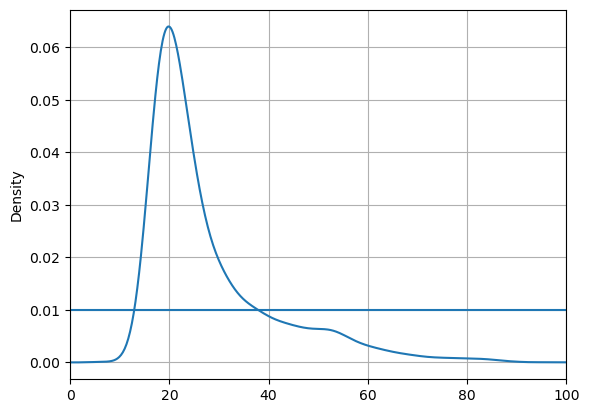

In [127]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.age.plot(kind='kde',xlim=(0,100), ax=ax)
ax.axhline(0.01)
ax.grid(True)

In [128]:
y_age = df['age']
y = df['age_quantiles']

df.drop(['sampling_rate', 'path', 'num_characters'], axis=1, inplace=True)
df['tempo'] = df['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df.drop('ethnicity', axis=1, inplace=True)
gender =  {'male': 1, 'female': 0, "famale": 0}
df['gender'] = df['gender'].map(gender)

X = df.drop(['age_quantiles', 'age'], axis=1)    

In [130]:
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error


# Define the stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

rl = []

for model in [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), SVR(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=30), MLPRegressor()]:
    rmses_per_class = []
    rmses = []

    # Split the data
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        z_train, z_test = y_age.iloc[train_index], y_age.iloc[test_index]


        # Remove outliers during training
        idx = y_train.isin(quantile_min_max[mask].index)
        X_train = X_train[~idx]
        y_train = y_train[~idx]
        z_train = z_train[~idx]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train the model
        model.fit(X_train, z_train)

        # Predict the age
        z_pred = model.predict(X_test)

        # Calculate RMSE for each class in y_test
        rmse_per_class = {}
        for cls in y_test.unique():
            idx = y_test == cls
            rmse_per_class[cls] = root_mean_squared_error(z_test[idx], z_pred[idx])
        
        print(f'{model.__class__.__name__} RMSE per class: {rmse_per_class}')
        rmses_per_class.append(rmse_per_class)

        # Calculate the overall RMSE
        rmse = root_mean_squared_error(z_test, z_pred)
        print(f'{model.__class__.__name__} RMSE: {rmse}')
        rmses.append(rmse)

    rmse_per_class = {cls: sum([d.get(cls, 0) for d in rmses_per_class])/5 for cls in y_test.unique()}
    rmse = sum(rmses)/5
    res = {'Model': model.__class__.__name__, 'RMSE': rmse} | {f'[{cls*5}-{5*(cls+1)}]': rmse_per_class[cls] for cls in y_test.unique()}
    rl.append(res)

df_res = pd.DataFrame(rl)

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


LinearRegression RMSE per class: {np.int64(4): np.float64(7.04013092109477), np.int64(6): np.float64(5.595104757361205), np.int64(3): np.float64(6.089237282714533), np.int64(10): np.float64(19.803838258036624), np.int64(11): np.float64(26.136075095139645), np.int64(16): np.float64(49.13791556564379), np.int64(5): np.float64(5.809822758876632), np.int64(7): np.float64(5.744217056882212), np.int64(8): np.float64(9.507268290542553), np.int64(12): np.float64(28.666239063953864), np.int64(14): np.float64(39.930028297111576), np.int64(9): np.float64(13.995815474886138), np.int64(13): np.float64(35.8441627839599), np.int64(15): np.float64(43.055819344714216), np.int64(17): np.float64(50.908941227460495), np.int64(19): np.float64(58.04607018927453)}
LinearRegression RMSE: 11.283298183996239
LinearRegression RMSE per class: {np.int64(4): np.float64(7.0806361963055275), np.int64(3): np.float64(6.96211977382614), np.int64(6): np.float64(5.904201065745815), np.int64(5): np.float64(5.25318418703102

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


RandomForestRegressor RMSE per class: {np.int64(4): np.float64(7.270239575720465), np.int64(6): np.float64(5.37858743818381), np.int64(3): np.float64(6.423232415494675), np.int64(10): np.float64(18.97965289461322), np.int64(11): np.float64(25.41537582982846), np.int64(16): np.float64(46.2247170533976), np.int64(5): np.float64(6.1305732453275965), np.int64(7): np.float64(6.334132469907893), np.int64(8): np.float64(9.341605236406489), np.int64(12): np.float64(28.450107381168177), np.int64(14): np.float64(38.791389589057005), np.int64(9): np.float64(14.155767683020663), np.int64(13): np.float64(36.47448893208982), np.int64(15): np.float64(39.61543175750244), np.int64(17): np.float64(52.43), np.int64(19): np.float64(58.15)}
RandomForestRegressor RMSE: 11.23097364003984
RandomForestRegressor RMSE per class: {np.int64(4): np.float64(7.606334309501981), np.int64(3): np.float64(6.903152934181041), np.int64(6): np.float64(5.18030348828804), np.int64(5): np.float64(6.052276723296245), np.int64(1

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


SVR RMSE per class: {np.int64(4): np.float64(4.344254654545246), np.int64(6): np.float64(6.458944907654489), np.int64(3): np.float64(4.0842248549664175), np.int64(10): np.float64(23.018776160175292), np.int64(11): np.float64(29.93259488201472), np.int64(16): np.float64(52.525104004753175), np.int64(5): np.float64(4.561924877313961), np.int64(7): np.float64(8.32295081785521), np.int64(8): np.float64(13.36607948435772), np.int64(12): np.float64(32.16577540541332), np.int64(14): np.float64(42.15586672556215), np.int64(9): np.float64(17.732351062611603), np.int64(13): np.float64(38.913596437351465), np.int64(15): np.float64(45.063524314142214), np.int64(17): np.float64(54.67770465082859), np.int64(19): np.float64(60.15476852638047)}
SVR RMSE: 11.76947195122444
SVR RMSE per class: {np.int64(4): np.float64(5.053962148392326), np.int64(3): np.float64(4.8844888849750365), np.int64(6): np.float64(5.415545074604317), np.int64(5): np.float64(4.317071980862427), np.int64(10): np.float64(22.9464176

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


KNeighborsRegressor RMSE per class: {np.int64(4): np.float64(7.113779346391571), np.int64(6): np.float64(4.820046256204362), np.int64(3): np.float64(6.144513874006898), np.int64(10): np.float64(19.821520571787065), np.int64(11): np.float64(26.4895831577814), np.int64(16): np.float64(49.097206113465845), np.int64(5): np.float64(5.750331006937115), np.int64(7): np.float64(5.8090108491954515), np.int64(8): np.float64(10.736541039462546), np.int64(12): np.float64(29.292906801628426), np.int64(14): np.float64(40.033875412649664), np.int64(9): np.float64(14.460115894792173), np.int64(13): np.float64(37.147221050113984), np.int64(15): np.float64(42.83917923790998), np.int64(17): np.float64(54.1), np.int64(19): np.float64(59.4)}
KNeighborsRegressor RMSE: 11.443199790713994
KNeighborsRegressor RMSE per class: {np.int64(4): np.float64(7.412129698451497), np.int64(3): np.float64(6.9426088065365095), np.int64(6): np.float64(4.159014768686672), np.int64(5): np.float64(5.520321604515805), np.int64(1

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor RMSE per class: {np.int64(4): np.float64(6.713607101938264), np.int64(6): np.float64(5.7058893033141915), np.int64(3): np.float64(6.058716861808095), np.int64(10): np.float64(19.78834840732497), np.int64(11): np.float64(25.373017417436632), np.int64(16): np.float64(48.93072568951152), np.int64(5): np.float64(6.132818509165997), np.int64(7): np.float64(5.716148664454202), np.int64(8): np.float64(9.65799499515715), np.int64(12): np.float64(28.38050007932357), np.int64(14): np.float64(38.895877264406764), np.int64(9): np.float64(14.242588464129865), np.int64(13): np.float64(35.31857977034095), np.int64(15): np.float64(42.20445824093422), np.int64(17): np.float64(50.45716464619072), np.int64(19): np.float64(53.327713486921546)}
MLPRegressor RMSE: 11.129091185643407


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor RMSE per class: {np.int64(4): np.float64(7.108369251402888), np.int64(3): np.float64(6.873940592464081), np.int64(6): np.float64(5.449564206772959), np.int64(5): np.float64(5.897423826982595), np.int64(10): np.float64(18.438863419058432), np.int64(8): np.float64(10.135522060517557), np.int64(14): np.float64(34.82130124399444), np.int64(9): np.float64(14.8567969972539), np.int64(12): np.float64(25.20823159745928), np.int64(7): np.float64(7.323299841917776), np.int64(13): np.float64(33.02915992758071), np.int64(11): np.float64(21.751010122728967), np.int64(1): np.float64(25.302712542212888), np.int64(15): np.float64(39.864606669685244), np.int64(17): np.float64(17.5594480676138), np.int64(16): np.float64(46.078868956360196)}
MLPRegressor RMSE: 10.498535816587687


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor RMSE per class: {np.int64(4): np.float64(6.09766132858344), np.int64(5): np.float64(5.616533711811016), np.int64(8): np.float64(9.6336911485484), np.int64(3): np.float64(6.295643518432684), np.int64(12): np.float64(28.02289976412785), np.int64(9): np.float64(15.93204917657197), np.int64(6): np.float64(5.050519417671116), np.int64(7): np.float64(7.598638642307273), np.int64(11): np.float64(25.55421674904876), np.int64(10): np.float64(17.91430683194672), np.int64(13): np.float64(32.02785073172984), np.int64(15): np.float64(40.580689316624785), np.int64(16): np.float64(47.425462950215994), np.int64(14): np.float64(37.43247887234844), np.int64(1): np.float64(18.996971331799383), np.int64(17): np.float64(50.750674820380475)}
MLPRegressor RMSE: 10.595642950252882
MLPRegressor RMSE per class: {np.int64(4): np.float64(7.040466681330972), np.int64(3): np.float64(5.951817144271305), np.int64(6): np.float64(6.230278252492911), np.int64(8): np.float64(10.074393545981764), np.int64(7):

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [131]:
df_res

,Model,RMSE,[20-25],[15-20],[30-35],[40-45],[35-40],[45-50],[25-30],[70-75],[65-70],[50-55],[55-60],[75-80],[80-85],[60-65],[85-90],[90-95]
0,LinearRegression,8.819040,5.451202,5.162740,4.274210,7.958041,5.614208,11.809455,4.434018,29.869790,27.327190,15.454787,20.023298,34.710328,38.950346,22.838481,35.734749,11.513491
1,Lasso,9.063886,5.025062,5.299217,3.376315,8.941249,5.875359,12.534399,3.546544,31.409992,28.672037,16.663786,20.923723,36.296497,40.206693,24.242652,38.929152,11.841974
2,Ridge,8.819465,5.451247,5.162648,4.268620,7.958035,5.611753,11.811010,4.432381,29.876919,27.330231,15.455526,20.026153,34.712542,38.954865,22.842389,35.768918,11.513621
3,RandomForestRegressor,8.802107,5.810979,5.251837,4.204936,7.782504,5.860742,11.315278,4.978082,28.770276,27.066909,14.739250,19.381900,33.118451,37.796783,22.466393,41.658000,11.482000
4,SVR,9.312498,3.672400,3.578868,4.873527,10.691304,7.681376,14.883054,3.523268,32.801860,29.578192,18.002002,23.185011,36.682754,41.922649,25.794076,44.802316,12.139027
5,DecisionTreeRegressor,11.268136,8.938732,7.660910,9.121411,12.712865,10.976874,13.925701,8.417068,30.397513,27.291786,17.739011,20.764246,32.421920,33.446695,23.939005,44.800000,10.000000
6,KNeighborsRegressor,8.910740,5.597955,5.257655,3.637765,8.065733,5.624357,11.869017,4.586096,30.534526,27.145763,15.199412,20.432301,34.389449,39.117674,23.103122,41.740000,11.760000
7,MLPRegressor,8.696166,5.392021,5.036024,4.487250,7.900320,5.942067,11.880399,4.743763,29.151825,26.180098,14.935289,20.016225,33.184902,38.749520,22.222332,33.737618,11.552917


In [132]:
# Ordina le colonne del dataframe
cols = ['Model', 'RMSE'] + sorted([col for col in df_res.columns if col.startswith('[')], key=lambda x: int(x.strip('[]').split('-')[0]))
df_res = df_res[cols]
df_res.set_index('Model', inplace=True)
df_res

,RMSE,[15-20],[20-25],[25-30],[30-35],[35-40],[40-45],[45-50],[50-55],[55-60],[60-65],[65-70],[70-75],[75-80],[80-85],[85-90],[90-95]
Model,,,,,,,,,,,,,,,,,
LinearRegression,8.819040,5.162740,5.451202,4.434018,4.274210,5.614208,7.958041,11.809455,15.454787,20.023298,22.838481,27.327190,29.869790,34.710328,38.950346,35.734749,11.513491
Lasso,9.063886,5.299217,5.025062,3.546544,3.376315,5.875359,8.941249,12.534399,16.663786,20.923723,24.242652,28.672037,31.409992,36.296497,40.206693,38.929152,11.841974
Ridge,8.819465,5.162648,5.451247,4.432381,4.268620,5.611753,7.958035,11.811010,15.455526,20.026153,22.842389,27.330231,29.876919,34.712542,38.954865,35.768918,11.513621
RandomForestRegressor,8.802107,5.251837,5.810979,4.978082,4.204936,5.860742,7.782504,11.315278,14.739250,19.381900,22.466393,27.066909,28.770276,33.118451,37.796783,41.658000,11.482000
SVR,9.312498,3.578868,3.672400,3.523268,4.873527,7.681376,10.691304,14.883054,18.002002,23.185011,25.794076,29.578192,32.801860,36.682754,41.922649,44.802316,12.139027
DecisionTreeRegressor,11.268136,7.660910,8.938732,8.417068,9.121411,10.976874,12.712865,13.925701,17.739011,20.764246,23.939005,27.291786,30.397513,32.421920,33.446695,44.800000,10.000000
KNeighborsRegressor,8.910740,5.257655,5.597955,4.586096,3.637765,5.624357,8.065733,11.869017,15.199412,20.432301,23.103122,27.145763,30.534526,34.389449,39.117674,41.740000,11.760000
MLPRegressor,8.696166,5.036024,5.392021,4.743763,4.487250,5.942067,7.900320,11.880399,14.935289,20.016225,22.222332,26.180098,29.151825,33.184902,38.749520,33.737618,11.552917


In [133]:
min_rmse_model = df_res.loc[df_res['RMSE'].idxmin()]
print(min_rmse_model)

RMSE        8.696166
[15-20]     5.036024
[20-25]     5.392021
[25-30]     4.743763
[30-35]     4.487250
[35-40]     5.942067
[40-45]     7.900320
[45-50]    11.880399
[50-55]    14.935289
[55-60]    20.016225
[60-65]    22.222332
[65-70]    26.180098
[70-75]    29.151825
[75-80]    33.184902
[80-85]    38.749520
[85-90]    33.737618
[90-95]    11.552917
Name: MLPRegressor, dtype: float64


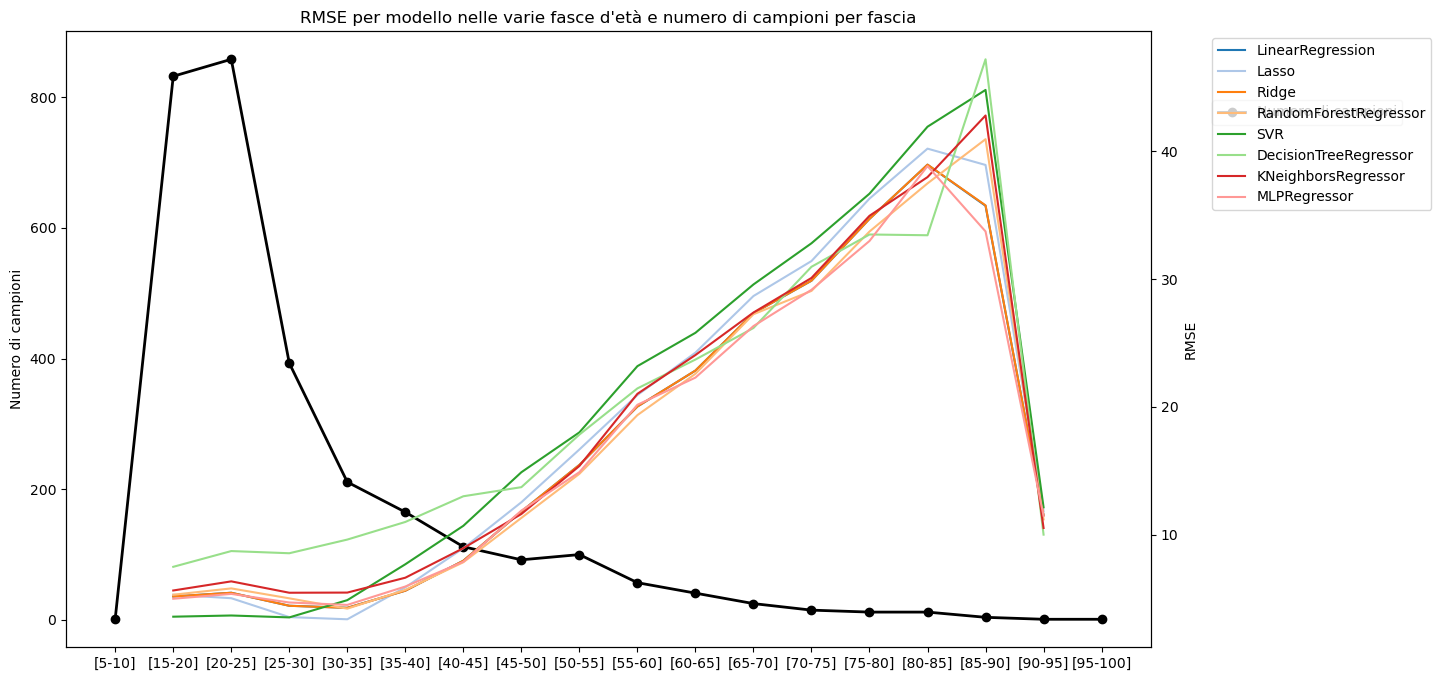

In [113]:
import matplotlib.pyplot as plt

# Creiamo una figura e un asse
fig, ax2 = plt.subplots(figsize=(14, 8))

# Impostiamo i colori per i diversi modelli
colors = plt.cm.tab20.colors

# Creiamo un asse secondario per il numero di campioni
ax1 = ax2.twinx()
# Plot della linea per il numero di campioni in ciascuna fascia d'età
ax2.plot([f'[{j*5}-{5*(j+1)}]' for j in quantile_min_max.index], quantile_min_max['count'], color='black', marker='o', linestyle='-', linewidth=2, label='Numero di campioni')

# Plot delle barre per ogni modello e fascia d'età
for i, model in enumerate(df_res.index):
    rmse_values = df_res.iloc[i, 1:].values
    ax1.plot(df_res.columns[1:], rmse_values, color=colors[i], label=model)



# Impostiamo le etichette degli assi
ax1.set_xlabel('Fasce d\'età')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('Numero di campioni')

# Impostiamo il titolo del grafico
plt.title('RMSE per modello nelle varie fasce d\'età e numero di campioni per fascia')

# Aggiungiamo le legende
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.9))

# Mostriamo il grafico
plt.show()

In [114]:
min_rmse_model = df_res.loc[df_res['RMSE'].idxmin()]
print(min_rmse_model)

RMSE        8.687546
[15-20]     4.982313
[20-25]     5.361791
[25-30]     4.689960
[30-35]     4.501586
[35-40]     5.939134
[40-45]     7.880997
[45-50]    11.881681
[50-55]    14.887508
[55-60]    20.161847
[60-65]    22.288824
[65-70]    26.320397
[70-75]    29.160776
[75-80]    32.981169
[80-85]    38.841101
[85-90]    33.727656
[90-95]    11.469233
Name: MLPRegressor, dtype: float64


In [115]:
reg = MLPRegressor()


# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train the model
reg.fit(X, y_age)

RandomForestRegressor()

In [116]:
ef = pd.read_csv('data/evaluation.csv').set_index('Id') 
ef.drop(['sampling_rate', 'path', 'num_characters', 'ethnicity'], axis=1, inplace=True)
ef['tempo'] = ef['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype(float)
ef['gender'] = ef['gender'].map(gender)

X_test = scaler.transform(ef)

z_pred = reg.predict(X_test)

pd.DataFrame({'Id': ef.index, 'Predicted': z_pred}).to_csv('out/wo-outliers.csv', index=False)


Another thing

In [117]:
X = df[df.age >= 40].drop(['age_quantiles', 'age'], axis=1)
y = df[df.age >= 40]['age_quantiles']
y_age = df[df.age >= 40]['age']

mask = quantile_min_max['count'] < 10


In [118]:
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error


# Define the stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

rl = []

for model in [LinearRegression, Lasso, Ridge, RandomForestRegressor, SVR, DecisionTreeRegressor, KNeighborsRegressor, MLPRegressor]:
    rmses_per_class = []
    rmses = []

    # Split the data
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        z_train, z_test = y_age.iloc[train_index], y_age.iloc[test_index]

        reg = model()

        # Remove outliers during training
        idx = y_train.isin(quantile_min_max[mask].index)
        X_train = X_train[~idx]
        y_train = y_train[~idx]
        z_train = z_train[~idx]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train the model
        reg.fit(X_train, z_train)

        # Predict the age
        z_pred = reg.predict(X_test)

        # Calculate RMSE for each class in y_test
        rmse_per_class = {}
        for cls in y_test.unique():
            idx = y_test == cls
            rmse_per_class[cls] = root_mean_squared_error(z_test[idx], z_pred[idx])
        
        print(f'{model.__name__} RMSE per class: {rmse_per_class}')
        rmses_per_class.append(rmse_per_class)

        # Calculate the overall RMSE
        rmse = root_mean_squared_error(z_test, z_pred)
        print(f'{model.__name__} RMSE: {rmse}')
        rmses.append(rmse)

    rmse_per_class = {cls: sum([d.get(cls, 0) for d in rmses_per_class])/5 for cls in y_test.unique()}
    rmse = sum(rmses)/5
    res = {'Model': model.__name__, 'RMSE': rmse} | {f'[{cls*5}-{5*(cls+1)}]': rmse_per_class[cls] for cls in y_test.unique()}
    rl.append(res)

df_res = pd.DataFrame(rl)

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


LinearRegression RMSE per class: {np.int64(10): np.float64(2.9213468510356098), np.int64(8): np.float64(11.240866771049058), np.int64(9): np.float64(6.342289768046399), np.int64(11): np.float64(4.466373865550275), np.int64(13): np.float64(15.16560878576556), np.int64(12): np.float64(9.116430216742703), np.int64(14): np.float64(20.424721107037772), np.int64(15): np.float64(22.321613146764705), np.int64(16): np.float64(29.166828189360462), np.int64(17): np.float64(32.33330952247834)}
LinearRegression RMSE: 10.741078721493503
LinearRegression RMSE per class: {np.int64(8): np.float64(11.30666195725971), np.int64(9): np.float64(6.310713472910917), np.int64(14): np.float64(19.38433099036878), np.int64(10): np.float64(2.945715023695278), np.int64(12): np.float64(8.232177543657713), np.int64(13): np.float64(13.117198990458814), np.int64(11): np.float64(4.940753532432703), np.int64(15): np.float64(22.48130779602273), np.int64(16): np.float64(29.170822800634298), np.int64(17): np.float64(31.5926

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


RandomForestRegressor RMSE per class: {np.int64(10): np.float64(4.95090739157985), np.int64(8): np.float64(12.347069490368959), np.int64(9): np.float64(6.597170012506351), np.int64(11): np.float64(4.190842397418447), np.int64(13): np.float64(14.602229281859671), np.int64(12): np.float64(8.039800992561942), np.int64(14): np.float64(20.379250885807032), np.int64(15): np.float64(20.310406199778477), np.int64(16): np.float64(27.027766586728298), np.int64(17): np.float64(32.51)}
RandomForestRegressor RMSE: 10.840958116391555
RandomForestRegressor RMSE per class: {np.int64(8): np.float64(10.938261810204189), np.int64(9): np.float64(7.71492568083903), np.int64(14): np.float64(22.199903152941907), np.int64(10): np.float64(2.7590882552031566), np.int64(12): np.float64(8.545358974320505), np.int64(13): np.float64(14.622170055872594), np.int64(11): np.float64(5.126510927103762), np.int64(15): np.float64(23.602918604839246), np.int64(16): np.float64(29.241452882281113), np.int64(17): np.float64(29

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

MLPRegressor RMSE per class: {np.int64(10): np.float64(12.017991529885935), np.int64(8): np.float64(14.473457442644287), np.int64(9): np.float64(13.359538948176283), np.int64(11): np.float64(17.296546472528107), np.int64(13): np.float64(26.87525451137987), np.int64(12): np.float64(20.445043600410173), np.int64(14): np.float64(38.10987155028947), np.int64(15): np.float64(34.454623977023246), np.int64(16): np.float64(28.875596701157715), np.int64(17): np.float64(49.41598727243903)}
MLPRegressor RMSE: 18.379767219001604


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor RMSE per class: {np.int64(8): np.float64(10.708129066804092), np.int64(9): np.float64(13.378497844359563), np.int64(14): np.float64(32.49807952311669), np.int64(10): np.float64(15.613975484887414), np.int64(12): np.float64(26.01209566517148), np.int64(13): np.float64(29.134800574424307), np.int64(11): np.float64(21.986504077699568), np.int64(15): np.float64(45.37764033942083), np.int64(16): np.float64(39.40600968500028), np.int64(17): np.float64(55.31209631753312)}
MLPRegressor RMSE: 20.793127933322626


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor RMSE per class: {np.int64(8): np.float64(16.71308223690607), np.int64(11): np.float64(16.428433709991634), np.int64(16): np.float64(52.802840475995396), np.int64(12): np.float64(24.617880244437607), np.int64(9): np.float64(11.994099484699214), np.int64(10): np.float64(15.782121870743378), np.int64(14): np.float64(26.113564701539072), np.int64(15): np.float64(41.72888053564356), np.int64(13): np.float64(29.49521608334005), np.int64(17): np.float64(52.71953096703914), np.int64(18): np.float64(66.71029776844055)}
MLPRegressor RMSE: 21.777205154062788
MLPRegressor RMSE per class: {np.int64(10): np.float64(18.342734296254736), np.int64(12): np.float64(23.485898193140734), np.int64(14): np.float64(32.63690991754103), np.int64(9): np.float64(13.088166882592818), np.int64(13): np.float64(29.90151238199106), np.int64(8): np.float64(10.966087833147233), np.int64(11): np.float64(14.760438242061571), np.int64(15): np.float64(41.571405164808176), np.int64(17): np.float64(7.365091963734

c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [119]:
# Ordina le colonne del dataframe
cols = ['Model', 'RMSE'] + sorted([col for col in df_res.columns if col.startswith('[')], key=lambda x: int(x.strip('[]').split('-')[0]))
df_res = df_res[cols]
df_res.set_index('Model', inplace=True)
df_res

,RMSE,[40-45],[45-50],[50-55],[55-60],[60-65],[65-70],[70-75],[75-80],[80-85],[85-90],[95-100]
Model,,,,,,,,,,,,
LinearRegression,8.845817,9.029104,5.204267,2.217607,4.011784,6.962855,11.541293,15.268967,18.494798,23.262194,22.881453,8.744259
Lasso,8.771965,8.729471,4.955746,1.339374,3.258161,7.043385,11.320707,15.301309,19.155276,23.408737,26.788896,8.826286
Ridge,8.843727,9.025369,5.200086,2.209512,4.003149,6.965370,11.534243,15.270119,18.499127,23.259357,22.910838,8.746532
RandomForestRegressor,8.960811,9.471932,5.847039,2.933110,3.469779,6.746544,11.651324,15.631746,17.957740,22.275984,23.650000,8.542000
SVR,8.901664,7.431000,3.564867,1.506161,4.697557,8.339667,12.593747,16.693276,20.129319,24.569874,27.709154,9.026996
DecisionTreeRegressor,12.053639,12.525468,9.659768,7.072701,8.841986,10.401316,14.813318,16.733603,19.224703,25.358633,21.400000,9.200000
KNeighborsRegressor,9.267444,9.427584,6.373844,3.583824,4.920904,8.272805,11.579738,14.114530,16.641750,22.038526,25.840000,10.080000
MLPRegressor,16.256991,10.572151,10.364061,12.351365,14.094385,18.912184,23.081357,25.871685,32.626510,33.231998,32.962541,11.915991


In [120]:
min_rmse_model = df_res.loc[df_res['RMSE'].idxmin()]
print(min_rmse_model)

RMSE         8.771965
[40-45]      8.729471
[45-50]      4.955746
[50-55]      1.339374
[55-60]      3.258161
[60-65]      7.043385
[65-70]     11.320707
[70-75]     15.301309
[75-80]     19.155276
[80-85]     23.408737
[85-90]     26.788896
[95-100]     8.826286
Name: Lasso, dtype: float64


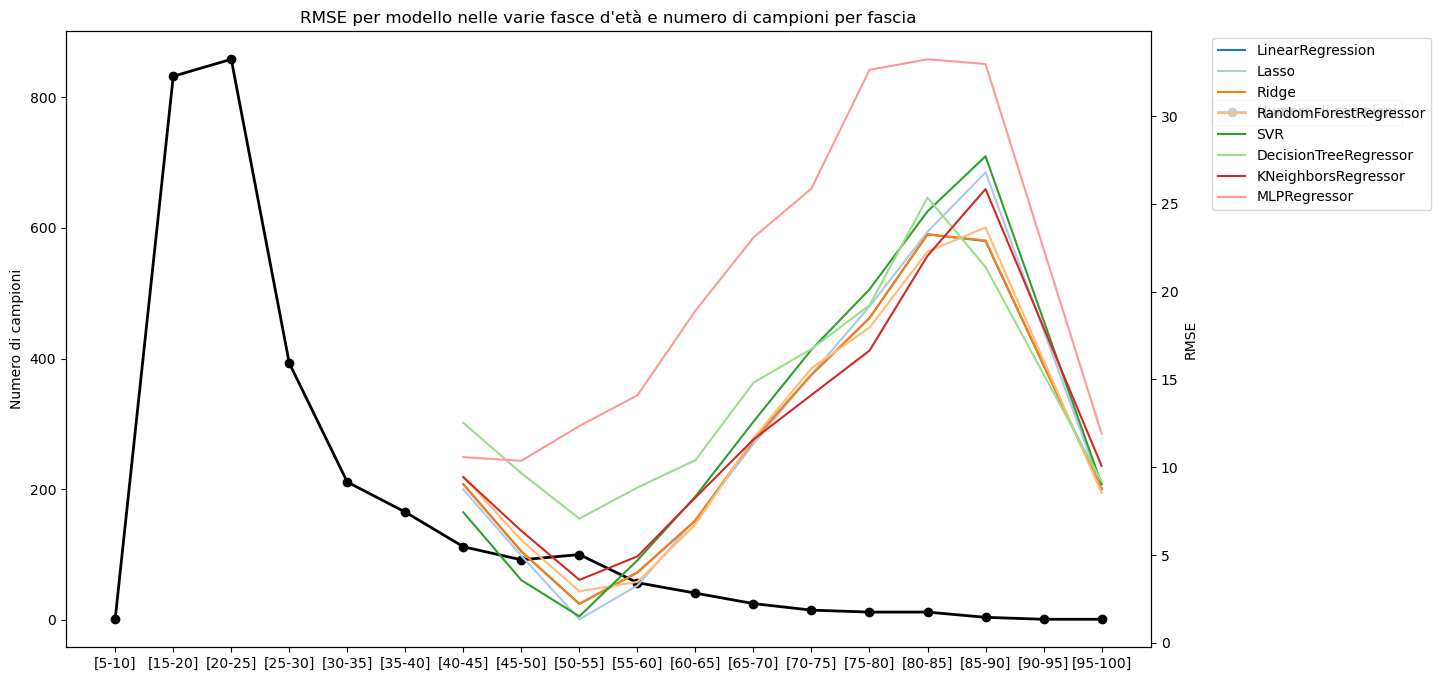

In [121]:
import matplotlib.pyplot as plt

# Creiamo una figura e un asse
fig, ax2 = plt.subplots(figsize=(14, 8))

# Impostiamo i colori per i diversi modelli
colors = plt.cm.tab20.colors

# Creiamo un asse secondario per il numero di campioni
ax1 = ax2.twinx()
# Plot della linea per il numero di campioni in ciascuna fascia d'età
ax2.plot([f'[{j*5}-{5*(j+1)}]' for j in quantile_min_max.index], quantile_min_max['count'], color='black', marker='o', linestyle='-', linewidth=2, label='Numero di campioni')

# Plot delle barre per ogni modello e fascia d'età
for i, model in enumerate(df_res.index):
    rmse_values = df_res.iloc[i, 1:].values
    ax1.plot(df_res.columns[1:], rmse_values, color=colors[i], label=model)



# Impostiamo le etichette degli assi
ax1.set_xlabel('Fasce d\'età')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('Numero di campioni')

# Impostiamo il titolo del grafico
plt.title('RMSE per modello nelle varie fasce d\'età e numero di campioni per fascia')

# Aggiungiamo le legende
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.9))

# Mostriamo il grafico
plt.show()